In [1]:
from calimba.data import *
from calimba.analysis import *
from calimba.atlas import *

In [2]:
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'
path_masks = '/media/anleg84/KINGSTON/Longitudinal/mapZebrain__regions/'

atlas = Mapzebrain(atlas_path)

# Atlas neuron reconstructions

(-0.5, 596.5, 973.5, -0.5)

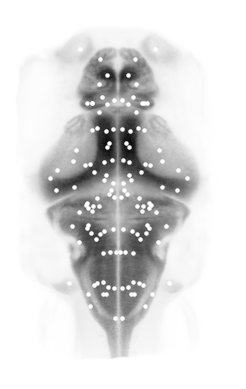

In [3]:
plt.imshow(atlas.XYprojection, cmap='binary')
plt.scatter(atlas.region_centroids[:, 0], atlas.region_centroids[:, 1], color='white', s=5)
plt.axis('off')

In [4]:
neurons = Neurons(atlas)

In [5]:
colors = generate_n_colors(10) * 1000
random_ids = np.arange(len(neurons.neurons))
np.random.shuffle(random_ids)

(-0.5, 358.5, 973.5, -0.5)

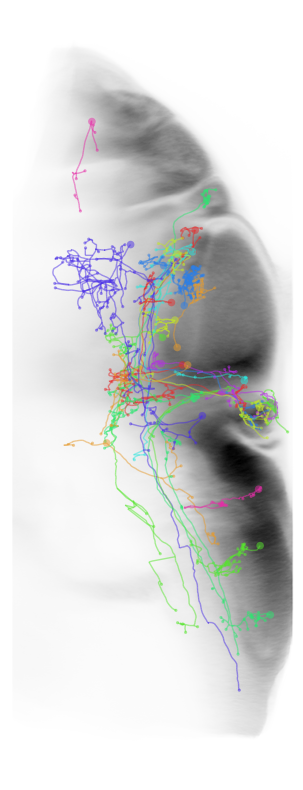

In [6]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(atlas.YZprojection, cmap='binary')
for i, j in enumerate(random_ids[:25]):
    neurons.plot_side(ax, j, color=colors[i], alpha=0.5)
plt.axis('off')

# Finding visuomotor pathways

In [7]:
from numba import njit

In [8]:
def compute_distances(X, Y):
    """
    Computes the pairwise distances between the rows of two numpy arrays.

    Parameters:
    X (np.ndarray): A numpy array of shape (n_samples_X, n_features).
    Y (np.ndarray): A numpy array of shape (n_samples_Y, n_features).

    Returns:
    np.ndarray: A numpy array of shape (n_samples_X, n_samples_Y) where
                each element (i, j) is the distance between X[i] and Y[j].
    """
    diff = X[:, np.newaxis, :] - Y[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff ** 2, axis=2))
    return distances

In [9]:
centroids_dark = np.load('Results/figure5_centroids_dark.npy')
centroids_motor = np.load('Results/figure5_centroids_motor.npy')
p_motor = np.load('Results/figure5_pvalues_motor.npy')
p_dark = np.load('Results/figure5_pvalues_dark.npy')
significance = 0.025

centroids_dark = centroids_dark[p_dark < significance]
centroids_motor = centroids_motor[p_motor < significance]

(65.0, 505.0, 850.0, 50.0)

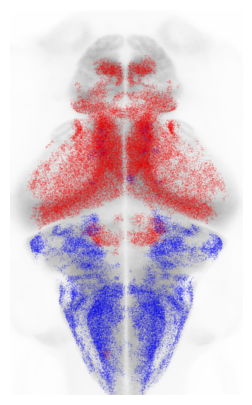

In [10]:
fig, ax = plt.subplots(figsize=(3, 5))
ax.imshow(atlas.XYprojection, aspect='auto', cmap='binary', vmin=0, vmax=2 * 89)
c1 = centroids_dark
c2 = centroids_motor
c = np.concatenate([c1, c2], axis=0)
colors = ['red'] * c1.shape[0] + ['blue'] * c2.shape[0]
order = np.arange(c.shape[0])
np.random.shuffle(order)
ax.scatter(c[order, 0], c[order, 1], color=np.array(colors)[order], alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.axis('off')


In [28]:
distances = compute_distances(neurons.somas, centroids_dark)
visual_neurons = np.min(distances, axis=1) < 5
print(np.sum(visual_neurons))

1121


In [29]:
del distances

In [30]:
distances = compute_distances(neurons.somas, centroids_motor)
motor_neurons = np.min(distances, axis=1) < 5
print(np.sum(motor_neurons))

426


In [27]:
del distances

In [32]:
visual_neurons[visual_neurons & motor_neurons] = 0
motor_neurons[visual_neurons & motor_neurons] = 0

#### Plotting visual neurons

In [34]:
visual_ids = np.where(visual_neurons)[0]

100%|███████████████████████████████████████| 1109/1109 [00:14<00:00, 74.93it/s]


(-0.5, 596.5, 973.5, -0.5)

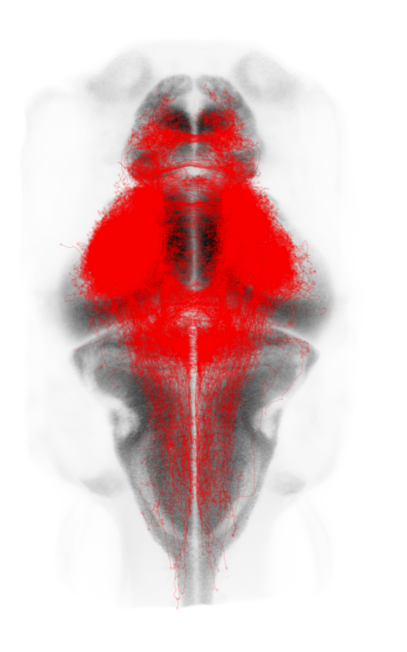

In [42]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(atlas.XYprojection, cmap='binary')
for i in tqdm(visual_ids):
    neurons.plot_top(ax, i, color='red', alpha=0.1, soma_size=30)
plt.axis('off')

100%|███████████████████████████████████████| 1109/1109 [00:13<00:00, 80.31it/s]


(-0.5, 358.5, 973.5, -0.5)

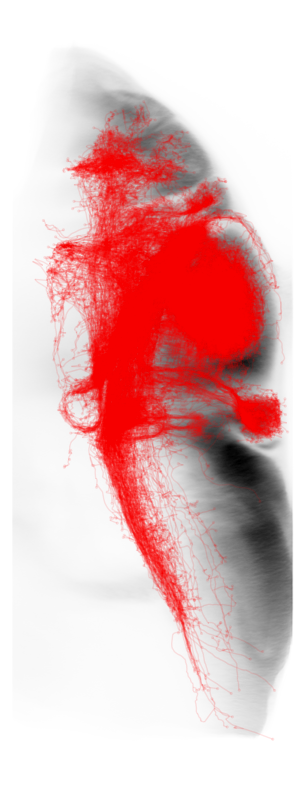

In [41]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(atlas.YZprojection, cmap='binary')
for i in tqdm(visual_ids):
    neurons.plot_side(ax, i, color='red', alpha=0.1, soma_size=30)
plt.axis('off')

#### Plotting motor neurons

In [43]:
motor_ids = np.where(motor_neurons)[0]

100%|████████████████████████████████████████| 426/426 [00:03<00:00, 126.65it/s]


(-0.5, 596.5, 1177.6117919935, -0.5)

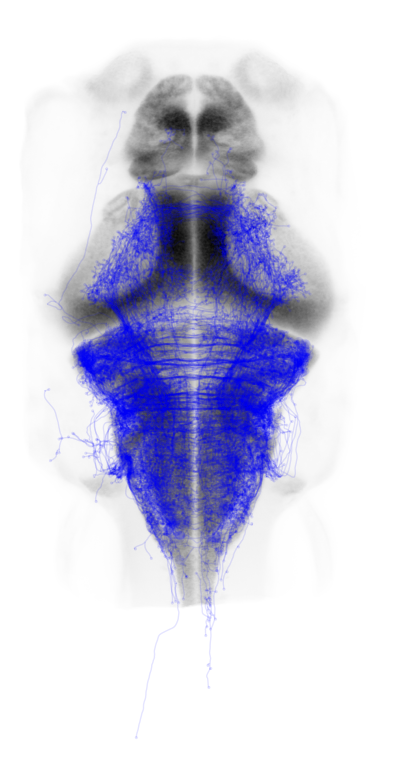

In [44]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(atlas.XYprojection, cmap='binary')
for i in tqdm(motor_ids):
    neurons.plot_top(ax, i, color='blue', alpha=0.1, soma_size=50)
plt.axis('off')

100%|████████████████████████████████████████| 426/426 [00:03<00:00, 115.92it/s]


(-74.73330287937003, 358.5, 1177.6117919935, -0.5)

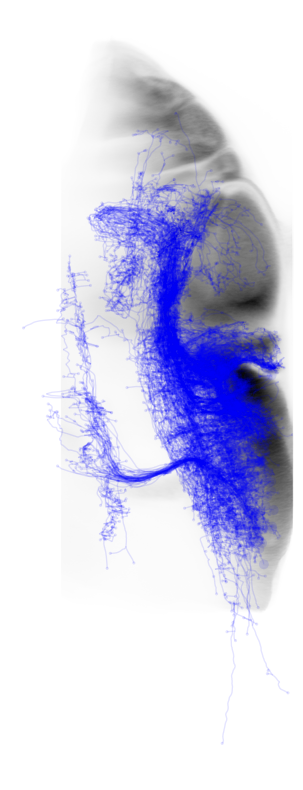

In [39]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(atlas.YZprojection, cmap='binary')
for i in tqdm(motor_ids):
    neurons.plot_side(ax, i, color='blue', alpha=0.1, soma_size=50)
plt.axis('off')

#### Terminal to soma connectivity

In [87]:
somas = np.concatenate([neurons.somas[visual_ids], neurons.somas[motor_ids]], axis=0)
terminals = []
for i in np.concatenate([visual_ids, motor_ids]):
    terminals.append(neurons.terminals[neurons.ids_terminals == i])

In [88]:
N = len(visual_ids) + len(motor_ids)
C = np.zeros((N, N))

for i in tqdm(range(N)):
    for j in range(N):
        terminals_j_near_soma_i = np.any(compute_distances(somas[i:i+1], terminals[j]) < 30)
        if terminals_j_near_soma_i:
            C[i, j] = 1

100%|███████████████████████████████████████| 1535/1535 [00:30<00:00, 49.54it/s]


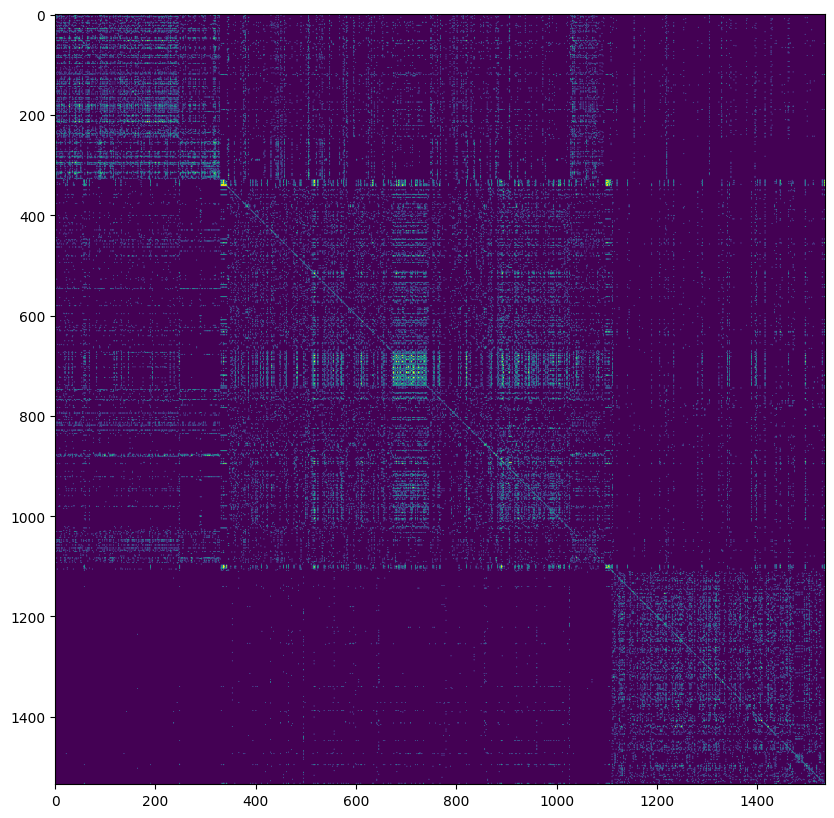

In [89]:
plt.figure(figsize=(10, 10))
plt.imshow(C)

In [90]:
visual_to_motor = np.sum(C[len(visual_ids):, :len(visual_ids)])
print(visual_to_motor)

1062.0


In [91]:
motor_to_visual = np.sum(C[:len(visual_ids), len(visual_ids):])
print(motor_to_visual)

4105.0


#### Terminal to terminal connectivity

In [82]:
N = len(visual_ids) + len(motor_ids)
C = np.zeros((N, N))

for i in tqdm(range(N)):
    for j in range(N):
        terminals_i_near_terminals_j = np.any(np.min(compute_distances(terminals[i], terminals[j]), axis=1) < 5)
        if terminals_i_near_terminals_j:
            C[i, j] = 1

100%|███████████████████████████████████████| 1535/1535 [01:49<00:00, 14.08it/s]


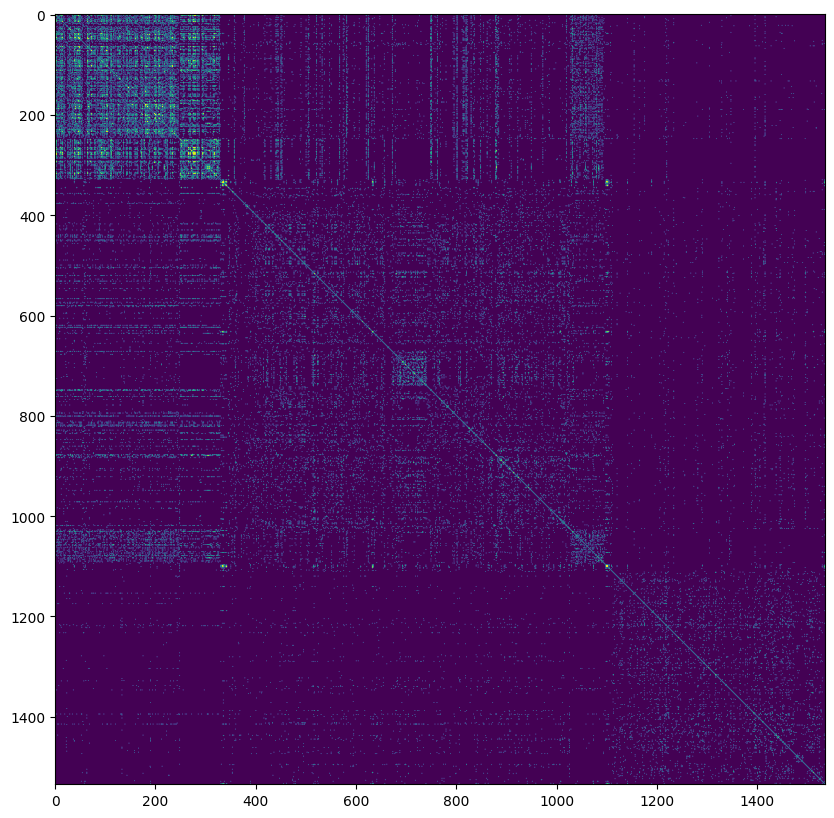

In [83]:
plt.figure(figsize=(10, 10))
plt.imshow(C)

In [85]:
visual_to_motor = np.sum(C[len(visual_ids):, :len(visual_ids)])
print(visual_to_motor)

2166.0


In [86]:
motor_to_visual = np.sum(C[:len(visual_ids), len(visual_ids):])
print(motor_to_visual)

2166.0


# Distribution of terminal distances from soma

In [96]:
distances = []
for i in range(neurons.somas.shape[0]):
    soma_i = neurons.somas[i:i+1]
    terminals_i = neurons.terminals[neurons.ids_terminals == i]
    distances.append(compute_distances(soma_i, terminals_i).flatten())

In [98]:
distances = np.concatenate(distances)

(array([1.514e+03, 4.120e+03, 5.527e+03, 6.566e+03, 7.347e+03, 7.434e+03,
        7.198e+03, 6.559e+03, 6.069e+03, 5.466e+03, 4.912e+03, 4.282e+03,
        3.921e+03, 3.445e+03, 2.948e+03, 2.552e+03, 2.289e+03, 2.091e+03,
        2.127e+03, 1.970e+03, 1.788e+03, 1.553e+03, 1.497e+03, 1.479e+03,
        1.317e+03, 1.226e+03, 1.269e+03, 1.203e+03, 1.099e+03, 1.141e+03,
        1.013e+03, 9.610e+02, 9.100e+02, 9.320e+02, 8.650e+02, 8.090e+02,
        7.830e+02, 7.470e+02, 6.740e+02, 6.550e+02, 5.580e+02, 5.000e+02,
        4.310e+02, 4.070e+02, 3.800e+02, 3.630e+02, 3.620e+02, 3.160e+02,
        3.270e+02, 2.570e+02, 2.220e+02, 1.720e+02, 2.040e+02, 1.710e+02,
        1.410e+02, 1.140e+02, 1.340e+02, 1.120e+02, 9.000e+01, 7.800e+01,
        5.900e+01, 4.800e+01, 3.800e+01, 4.100e+01, 3.900e+01, 3.300e+01,
        3.000e+01, 2.000e+01, 1.500e+01, 1.900e+01, 2.400e+01, 1.900e+01,
        7.000e+00, 8.000e+00, 3.000e+00, 7.000e+00, 5.000e+00, 7.000e+00,
        5.000e+00, 5.000e+00, 0.000e+0

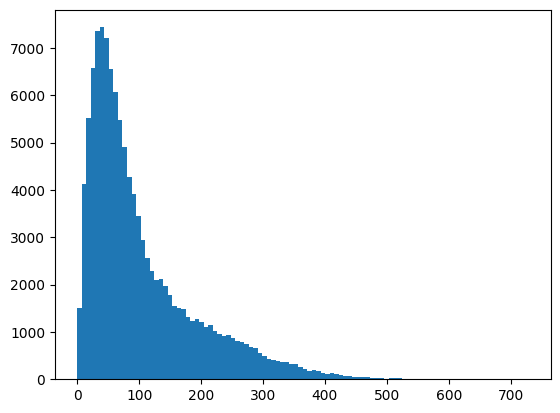

In [101]:
plt.hist(distances, bins=100)